In [50]:
import math
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras import layers,  Input
from tensorflow.keras.layers import InputLayer,  Flatten
from  keras.layers.core import Dense
from tensorflow.keras.models import Sequential, Model
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
from keras import backend as K
import glob
from os.path import join, basename
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from keras.layers import merge

BASE_PATH = 'jpeg-melanoma-512x512/train/'
batch_size = 4

def PSNR(y_true, y_pred):
    max_pixel = 1.0
    return (10.0 * K.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true), axis=-1)))) / 2.303

all_images = glob.glob(join(BASE_PATH, "*R.jpg"))
all_images = [basename(x) for x in all_images]
all_images.sort()

X = [fname.split(".")[0][:-1] + ".jpg" for fname in all_images]
Y = all_images

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.10, random_state=42)

class data_generator(keras.utils.Sequence) :
  
  def __init__(self, x_image_filenames, y_image_filenames, batch_size) :
    self.image_filenames = x_image_filenames
    self.labels = y_image_filenames
    self.batch_size = batch_size
    
    
  def __len__(self) :
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
  
  
  def __getitem__(self, idx) :
    batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    
    return (np.array([resize(imread(join(BASE_PATH, file_name)), (512, 512, 3)) for file_name in batch_x])/255.0), \
           (np.array([resize(imread(join(BASE_PATH, file_name)), (512, 512, 3)) for file_name in batch_y])/255.0)


train_gen = data_generator(X_train, Y_train, batch_size)
val_gen = data_generator(X_val, Y_val, batch_size)
test_gen = data_generator(X_test, Y_test, batch_size)


encodeco_input = keras.Input(shape=(512, 512, 3), name="original_img")
x = layers.Conv2D(128, 3,strides=(1, 1),padding="same", activation="relu")(encodeco_input)
x1 = layers.MaxPooling2D(strides=2)(x)
x2 = layers.Conv2D(256, 3, strides=(1, 1),padding="same", activation="relu")(x1)
x3 = layers.MaxPooling2D(strides=2)(x2)
x4 = layers.Conv2D(256, 3, strides=(1, 1), padding="same", activation="relu")(x3)
x5 = layers.UpSampling2D(2)(x4)
SkipConn1 = layers.concatenate([x2, x5])
x6 = layers.Conv2DTranspose(128, 3, strides=(1, 1), padding="same", activation="relu")(SkipConn1)
SkipConn2 = layers.concatenate([x1, x6])
x7 = layers.UpSampling2D(2)(SkipConn2)
SkipConn3 = layers.concatenate([x, x7])
x8 = layers.Conv2DTranspose(128, 3, strides=(1, 1), padding="same", activation="relu")(SkipConn3)
encodeco_output = layers.Conv2DTranspose(3, 3, strides=(1, 1), padding="same", activation="relu")(x8)
 

encodecoder = keras.Model(encodeco_input, encodeco_output, name="encoderdecoder")
opt = keras.optimizers.Adam(learning_rate=0.001)
encodecoder.compile(loss='mean_squared_error', optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError(), PSNR])

encodecoder.fit_generator(generator=train_gen, validation_data=val_gen, epochs = 1)
encodecoder.save('./')

/scratch/local/27994681/ipykernel_114918/2036536143.py:84: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  encodecoder.fit_generator(generator=train_gen, validation_data=val_gen, epochs = 1)
/scratch/local/27994681/ipykernel_114918/2036536143.py:48: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)


1489/1489 [==============================] - 1123s 754ms/step - loss: 2.3782e-06 - root_mean_squared_error: 0.0015 - PSNR: 57.0425 - val_loss: 2.3212e-06 - val_root_mean_squared_error: 0.0015 - val_PSNR: 57.1028
INFO:tensorflow:Assets written to: ./assets


In [51]:
batch_num = 0
predictions = encodecoder.predict(test_gen[batch_num][0])

Test images


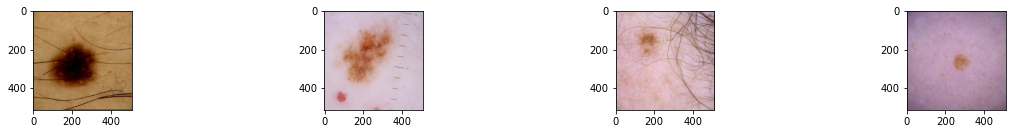

Test images hairless


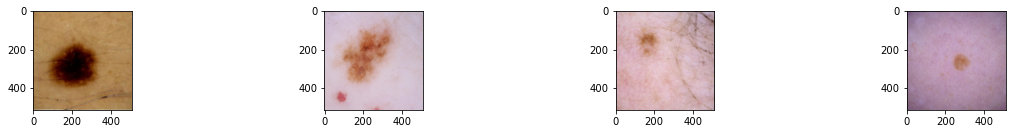

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


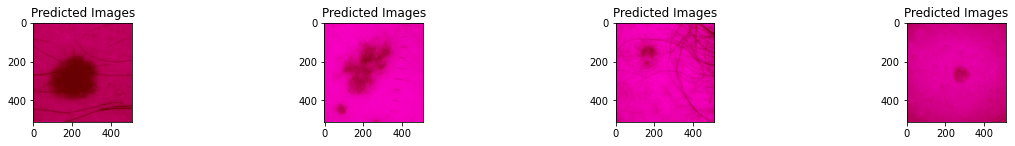

In [52]:
plt.figure(figsize=(20, 4))
print("Test images")
for i in range(0,4,1):
    plt.subplot(2, 4, i+1)
    plt.imshow(test_gen[batch_num][0][i,:,:] * 255)
plt.show()
 

plt.figure(figsize=(20, 4))
print("Test images hairless")
for i in range(0,4,1):
    plt.subplot(2, 4, i+1)
    plt.imshow(test_gen[batch_num][1][i,:,:] * 255)
plt.show()

prediction = predictions
plt.figure(figsize=(20, 4))
for i in range(0,4,1):
    plt.subplot(2, 4, i+1)
    plt.imshow((predictions[i,:,:, :] * 255))
    plt.title("Predicted Images")  
plt.show()

In [55]:
from skimage import data, io
np.max(predictions[0, :, :, 2])

0.0020289174